# Categorize rice leafs by their diseases
This notebook consists of the leaf detection part, and the neural net part.

## Detection functions
Here we detect the borders of the leaf in the image.

In [1]:
import cv2
from scipy import ndimage
import numpy as np
from math import sqrt, pi, atan2, atan

sharpen_cnn = np.array([[0, 0, 0, -1, 0, 0, 0],
                        [0, 0, -1, -1, -1, 0, 0],
                        [0, -1, -1, -1, -1, -1, 0],
                        [-1, -1, -1, 24, -1, -1, -1],
                        [0, -1, -1, -1, -1, -1, 0],
                        [0, 0, -1, -1, -1, 0, 0],
                        [0, 0, 0, -1, 0, 0, 0]])

len_threshold_1 = 0.40
len_threshold_other = 0.8
angle_diff_threshold = 10 * (pi / 180)
OUT_W, OUT_H = 800, 100
RECIZE_SZ = 1024

def find_longest_lines_in_contour(contours) -> list:
    full_list = []
    for c in contours:
        peri = cv2.arcLength(c, True)
        poly = cv2.approxPolyDP(c, 0.02 * peri, True)
        for lin_i in range(len(poly))[:-1]:
            full_list.append(((poly[lin_i][0][0], poly[lin_i][0][1]), (poly[lin_i + 1][0][0], poly[lin_i + 1][0][1])))
    full_list = sorted(full_list, key=lambda x: -(x[0][0] - x[1][0]) ** 2 - (x[0][1] - x[1][1]) ** 2)
    return full_list

# k = (y1 - y2) / (x1 - x2)
# b = y2 - k*x2
def line_koeff(line: tuple[tuple[int, int], tuple[int, int]]) -> tuple[float, float]:
    k = (line[0][1] - line[1][1]) / (line[0][0] - line[1][0])
    b = line[1][1] - k * line[1][0]
    return k, b

def angle_diff(lhs, rhs) -> float:
    k_l, _ = line_koeff(lhs)
    k_r, _ = line_koeff(rhs)
    return abs(atan(k_l) - atan(k_r))

def line_len_f(x):
    return sqrt((x[0][0] - x[1][0]) ** 2 + (x[0][1] - x[1][1]) ** 2)

def find_candidate_lines(image_data) -> list:
    gray = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY) # convert image into monochannel

    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9) # former: 21
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=9) # changed for the perfomance

    grad = np.sqrt(grad_x ** 2 + grad_y ** 2) # unite horizontal and vertical Sobel filtered images into one
    grad = (grad * 255 / grad.max()).astype(np.uint8) # make image be an 2D-array of numbers [0..255]
    grad[np.abs(grad) < 64] = 0 # zero out noizes
    grad = grad.astype(np.float) # here we have image, that consists only from edges
    grad = ndimage.convolve(grad, sharpen_cnn, mode='constant', cval=0.0) # sharpen the edges, because there are a lot of images that are quite blured
    grad[grad > 255] = 255 # just normalize, nothing interesting
    grad[grad < 64] = 0
    grad = grad.astype(np.uint8) # convert it back

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)) # make dots more looking like a line
    closed = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)

    (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # finally find the contours
    all_lines = find_longest_lines_in_contour(cnts) # here we use all contours just as a set of lines from point to point
    longest = all_lines[:min(10, len(all_lines))] # longest 10 lines

    # here we filter dicks that are not big enough
    if len(longest) <= 2:
        return longest
    target = list()
    target.append(longest[0])  # at least 1 should be here
    current_thr = len_threshold_1
    for line in longest[1:]:
        prev_len = line_len_f(target[-1])
        current_len = line_len_f(line)
        if current_len < prev_len * current_thr: # filter lines by length
            break
        if angle_diff(target[0], line) > angle_diff_threshold: # line should not be an angle
            continue
        target.append(line)
        current_thr = len_threshold_other

    return target

def restrict(x, mn, mx): # just a normalize function, nothing interesting
    return int(max(mn, min(mx, x)))

# given two lines formed by f(x)=k*x+b and point on the first line, find the intersection of the second line with the first line's perpendicular in that point
def find_intersection(k1: float, b1: float, k2: float, b2: float, x1: float, size: int, recursive: bool = True) -> tuple[float, float]:
    y1 = k1 * x1 + b1
    x_r = (y1 + x1 / k1 - b2) / (k2 + 1 / k1)
    y_r = x_r * k2 + b2
    if x_r < -1:
        if not recursive:
            return int(0), int(b2)
        res = find_intersection(k2, b2, k1, b1, 1, size, False)
        return find_intersection(k1, b1, k2, b2, res[0], size, False)
    elif y_r < -1:
        if not recursive:
            return int(-b2 / k2), int(0)
        res = find_intersection(k2, b2, k1, b1, (-b2) / k2, size, False)
        return find_intersection(k1, b1, k2, b2, res[0], size, False)
    elif x_r > size:
        if not recursive:
            return int(size - 1), int((size - 1) * k2 + b2)
        res = find_intersection(k2, b2, k1, b1, (size - 1), size, False)
        return find_intersection(k1, b1, k2, b2, res[0], size, False)
    elif y_r > size:
        if not recursive:
            return int((size - 1) - b2 / k2), int((size - 1))
        res = find_intersection(k2, b2, k1, b1, (((size - 1) - b2) / k2), size, False)
        return find_intersection(k1, b1, k2, b2, res[0], size, False)
    return x_r, y_r

# sort points counterclockwise
def sort_counterclock(pts: tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]) -> tuple[
    tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]:
    avg_x, avg_y = (pts[0][0] + pts[1][0] + pts[2][0] + pts[3][0]) / 4, (
            pts[0][1] + pts[1][1] + pts[2][1] + pts[3][1]) / 4
    result = list(pts)
    result = sorted(result, key=lambda pt: atan2((pt[0] - avg_x), (pt[1] - avg_y)))
    if line_len_f((result[0], result[1])) > line_len_f((result[1], result[2])):
        return result[1], result[2], result[3], result[0]
    return result[0], result[1], result[2], result[3]

def normalize_fit_tetragon(tetragon: tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]],
                           size: int) -> tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]:
    result = list()
    for x in tetragon:
        result.append((restrict(x[0], 0, size), restrict(x[1], 0, size)))
    return result[0], result[1], result[2], result[3]

# take image and four points and extract image within this tetragon into OUT_WxOUT_H image
def extract_maiha(image: np.ndarray, tetragon: tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]) -> np.ndarray:
    stetra = sort_counterclock(tetragon)
    inp_pts = np.array(stetra, dtype=np.float32)
    outp_pts = np.array([[0, 0], [0, OUT_H], [OUT_W, OUT_H], [OUT_W, 0]], dtype=np.float32)
    transform_mat = cv2.getPerspectiveTransform(inp_pts, outp_pts)
    return cv2.warpPerspective(image, transform_mat, (OUT_W, OUT_H), flags=cv2.INTER_LINEAR)

# take pointed line and functional line and return four points of tetragon, needed to extract image
def find_rect_by_two_lines(line_ichi: tuple[tuple[int, int], tuple[int, int]], k2: float, b2: float, size: int) -> tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]:
    k1, b1 = line_koeff(line_ichi)
    sanme_point = find_intersection(k1, b1, k2, b2, line_ichi[0][0], size)
    yonme_point = find_intersection(k1, b1, k2, b2, line_ichi[1][0], size)
    sanme_point = restrict(sanme_point[0], 0, size - 1), restrict(sanme_point[1], 0, size - 1)
    yonme_point = restrict(yonme_point[0], 0, size - 1), restrict(yonme_point[1], 0, size - 1)
    return normalize_fit_tetragon((line_ichi[0], line_ichi[1], sanme_point, yonme_point), size)

def is_valid_rect(rect: tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]], size: int) -> bool:
    for x in rect:
        if x[0] >= size or x[1] >= size or x[0] < 0 or x[1] < 0:
            return False
    return True

# remove background from image
# as it does remove parts of the leafs too, it is used only in scoring the image
def rm_background(image: np.ndarray) -> np.ndarray:
    lower = np.array([128, 64, 128])
    upper = np.array([255, 255, 255])
    thresh = cv2.inRange(image, lower, upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    mask = 255 - morph
    result = cv2.bitwise_and(image, image, mask=mask)
    return result

def compute_image_score(image: np.ndarray, hght: float) -> float:  # we should keep it as low as possible
    blured = cv2.blur(image, (9, 9)) # blur, because some parts of the leafs may be black, and worthen the score
    nonz = float(np.count_nonzero(blured))
    all_pix = blured.shape[0] * blured.shape[1] * blured.shape[2]
    score = -((hght) ** (1)) + (((all_pix - nonz + 1) / all_pix * 256) ** 2) # less is better
    return score

# this algo is similar to binary search around the main line
# we build lines +-step and look at the score
# then choose the less one and divide step by 2
def find_rect_no_hint(image: np.ndarray, line: tuple[tuple[int, int], tuple[int, int]], size: int) -> tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]:
    b_step = 2 ** 8
    k1, b1 = line_koeff(line)
    result: tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]] = (0, 0), (0, 0), (0, 0), (0, 0)
    k_c, b_c = k1, b1
    scoring_image = rm_background(image)
    while b_step >= 1:
        kl, bl = k_c, b_c + b_step  # low
        kh, bh = k_c, b_c - b_step  # high
        rect_l, rect_h = find_rect_by_two_lines(line, kl, bl, size), find_rect_by_two_lines(line, kh, bh, size)
        img_l = extract_maiha(scoring_image, rect_l)
        img_h = extract_maiha(scoring_image, rect_h)
        score_l = compute_image_score(img_l, abs(b1 - bl))
        score_h = compute_image_score(img_h, abs(b1 - bh))
        if score_l < score_h:
            k_c, b_c = kl, bl
            result = rect_l
        else:
            k_c, b_c = kh, bh
            result = rect_h
        b_step = int(b_step / 2)
    return result


def get_rect_no_hint(image: np.ndarray, line: tuple[tuple[int, int], tuple[int, int]], size: int) -> np.ndarray:
    tetragon = find_rect_no_hint(image, line, size)
    return extract_maiha(image, tetragon)

# in previous works there was usage of other lines too, but we decided to continue with
# main line only, because it gives less distorted results
def process_image(image: np.ndarray, size: int) -> np.ndarray:
    lines = find_candidate_lines(image)
    if len(lines) >= 1:
        return get_rect_no_hint(image, lines[0], size)
    return cv2.resize(image, (OUT_W, OUT_H))

def process_image_from_file_to_file(path: str, store_path: str):
    image = cv2.imread(path)
    image = cv2.resize(image, (RECIZE_SZ, RECIZE_SZ))
    image = process_image(image, RECIZE_SZ)
    cv2.imwrite(store_path, image)

def read_from_origin(path: str) -> np.ndarray:
    image = cv2.imread(path)
    image = cv2.resize(image, (RECIZE_SZ, RECIZE_SZ))
    return process_image(image, RECIZE_SZ)

In [2]:
%%time
import os
from os.path import join as pjoin, isfile

CACHE_DIR = "maihacache"
READ_DIR = "RiceLeafs"
counter = 0

def precache_leafs(path: str, store_path: str):
    global counter
    os.mkdir(store_path)
    for entry in os.listdir(path):
        fpath = pjoin(path, entry) # folded
        ftarget = pjoin(store_path, entry)
        if isfile(fpath):
            process_image_from_file_to_file(fpath, ftarget)
            counter += 1
        else:
            precache_leafs(fpath, ftarget)

# precache_leafs(READ_DIR, CACHE_DIR)
print("Total images cached: ", counter)
counter = 0

Total images cached:  0
CPU times: user 373 µs, sys: 0 ns, total: 373 µs
Wall time: 221 µs


In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# tf.debugging.set_log_device_placement(True)
tf.config.set_soft_device_placement(True)

print(tf.config.experimental.list_physical_devices())

gpu = tf.config.list_logical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpu[0], True)

print(gpu)

2022-01-26 03:08:42.058139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-01-26 03:08:42.094139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 03:08:42.094378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 03:08:42.113895: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-26 03:08:42.115092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
202

In [4]:
LEARNING_RATE = 0.001

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, (3, 3), activation = 'relu', input_shape = (OUT_W, OUT_H, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(8, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(10, (5, 5), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(4, 4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation = 'softmax')
],    name = 'Maiha')

model.summary()

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

Model: "Maiha"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 798, 98, 6)        168       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 399, 49, 6)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 397, 47, 8)        440       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 198, 23, 8)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 194, 19, 10)       2010      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 4, 10)        0     

In [5]:
train_dir = pjoin(CACHE_DIR, 'train')
test_dir = pjoin(CACHE_DIR, 'validation')
classes = []
for file in os.listdir(train_dir):
    classes += [file]
print(classes)
print(len(classes))

['BrownSpot', 'LeafBlast', 'Healthy', 'Hispa']
4


In [6]:
brownSpot = [train_dir + '/BrownSpot/' + img for img in os.listdir(train_dir + '/BrownSpot')[:9]]
healthy = [train_dir  + '/Healthy/' + img for img in os.listdir(train_dir + '/Healthy')[:9]]
hispa = [train_dir  + '/Hispa/' + img for img in os.listdir(train_dir + '/Hispa')[:9]]
leafBlast = [train_dir  + '/LeafBlast/' + img for img in os.listdir(train_dir + '/LeafBlast')[:9]]

In [7]:
def load_dataset(datadir: str):
    target_set = list()
    shape=(OUT_W, OUT_H)
    counter = 0
    for file in os.listdir(datadir):
        path=os.path.join(datadir, file)
        for im in os.listdir(path):
            image = tf.keras.preprocessing.image.load_img(os.path.join(path, im), grayscale=False, color_mode='rgb', target_size=shape)
            image = tf.keras.preprocessing.image.img_to_array(image)
            image = image / 255.0
            target_set += [[image, counter]]
        counter += 1
    return target_set

In [8]:
dataset = load_dataset(train_dir)
testset = load_dataset(test_dir)

In [9]:
data, trainlabels = zip(*dataset)
test, testlabels = zip(*testset)
labels = np.array(tf.keras.utils.to_categorical(trainlabels, num_classes=4))
data = np.array(data)
test = np.array(test)
trainx, testx, trainy, testy = train_test_split(data, labels, test_size=0.2, random_state=42)
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(2147, 800, 100, 3)
(537, 800, 100, 3)
(2147, 4)
(537, 4)


In [10]:
del dataset[:]
del dataset
del testset[:]
del testset
dataset = None
testset = None

In [11]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=5, zoom_range=0.2, width_shift_range=0.1,height_shift_range=0.1,shear_range=0.2)

In [12]:
his = model.fit(datagen.flow(trainx, trainy, batch_size=32), validation_data=(testx, testy), epochs=20)

Epoch 1/20


2022-01-26 03:08:50.796359: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300


68/68 [==============================] - 37s 487ms/step - loss: 1.2925 - accuracy: 0.4425 - val_loss: 1.1709 - val_accuracy: 0.5382
Epoch 2/20
68/68 [==============================] - 32s 469ms/step - loss: 1.2072 - accuracy: 0.4946 - val_loss: 1.1308 - val_accuracy: 0.5419
Epoch 3/20
68/68 [==============================] - 33s 479ms/step - loss: 1.1857 - accuracy: 0.5105 - val_loss: 1.1107 - val_accuracy: 0.5419
Epoch 4/20
68/68 [==============================] - 33s 485ms/step - loss: 1.1571 - accuracy: 0.5128 - val_loss: 1.1102 - val_accuracy: 0.5345
Epoch 5/20
68/68 [==============================] - 32s 474ms/step - loss: 1.1509 - accuracy: 0.5128 - val_loss: 1.1260 - val_accuracy: 0.5251
Epoch 6/20
68/68 [==============================] - 33s 479ms/step - loss: 1.1378 - accuracy: 0.5170 - val_loss: 1.0709 - val_accuracy: 0.5773
Epoch 7/20
68/68 [==============================] - 33s 477ms/step - loss: 1.1181 - accuracy: 0.5282 - val_loss: 1.0445 - val_accuracy: 0.6089
Epoch 8/20

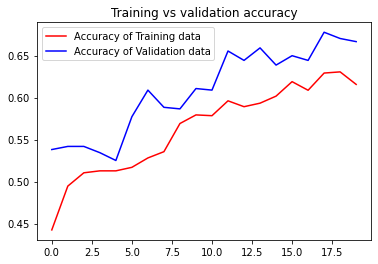

<Figure size 432x288 with 0 Axes>

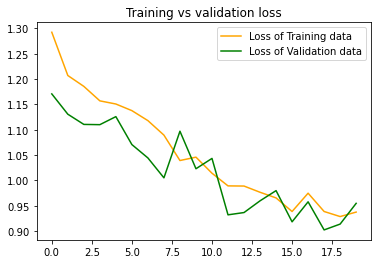

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, get_loss, 'orange', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'green', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()